# Machine Learning for String Field Theory

H. Erbin, R. Finotello, M. Kudrna, M. Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we use the Python implementation of [Stacknet](https://github.com/h2oai/pystacknet) to provide an additional implementation of *ensemble learning* techniques.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

In [3]:
import os
import logging

# set less logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [4]:
import numpy as np
import tensorflow as tf

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Installing Stacknet

we first need to install Stacknet.

In [5]:
!pip install git+https://github.com/thesfinox/pystacknet

  Cloning https://github.com/thesfinox/pystacknet to /tmp/pip-req-build-b4lkepq4
  Running command git clone -q https://github.com/thesfinox/pystacknet /tmp/pip-req-build-b4lkepq4
  Created wheel for pystacknet: filename=pystacknet-0.0.1-py3-none-any.whl size=23460 sha256=344a43e8561df8d384d3ab2ed8decb15c189c5f523820c7d66387cd941ce32b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rozki8jn/wheels/4b/a0/ad/c7ebca734db3db2384b66b2c4b6f170cbaec085d98b076c466
Successfully built pystacknet


## Preparing the Input Dataset

We then prepare the input dataset using 90% of the data for training and 10% for testing purposes.
In this case we consider the problem of predicting separately the real and the imaignary parts of the extrapolated labels.

In [6]:
import pandas as pd

# load the features
X_train = pd.read_csv('./data/X_train_cv.csv')
X_test  = pd.read_csv('./data/X_test.csv')

# load the labels
y_train_re = pd.read_csv('./data/y_train_cv.csv')[['exp_re']]
y_train_im = pd.read_csv('./data/y_train_cv.csv')[['exp_im']]
y_test_re  = pd.read_csv('./data/y_test.csv')[['exp_re']]
y_test_im  = pd.read_csv('./data/y_test.csv')[['exp_im']]

In [7]:
%%script false --no-raise-error

from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Implementing StackNet

We finally try to implement the StackNet using several different algorithms.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

# First level algorithms
ridge_lv1 = Ridge(alpha=1.0e-5,
                  fit_intercept=True,
                  normalize=True,
                  random_state=RAND
                 )
svr_lv1   = SVR(kernel='rbf',
                C=1.0e1,
                epsilon=0,
                gamma=1.0
               )
rf_lv1    = LGBMRegressor(boosting_type='rf',
                          num_leaves=500,
                          max_depth=-1,
                          n_estimators=100,
                          objective='regression',
                          subsample_freq=1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          reg_alpha=1.0e-4,
                          reg_lambda=1.0e-3,
                          random_state=RAND,
                          n_jobs=-1
                         )
gbdt_lv1  = LGBMRegressor(boosting_type='gbdt',
                          learning_rate=1.0e-3,
                          num_leaves=50,
                          max_depth=-1,
                          n_estimators=6000,
                          objective='regression',
                          subsample_freq=1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          reg_alpha=1.0e-4,
                          reg_lambda=1.0e-3,
                          random_state=RAND,
                          n_jobs=-1
                         )

# Second level algorithms
svr_lv2   = SVR(kernel='rbf',
                C=1.0e2,
                epsilon=0.1,
                gamma=10.0
               )
rf_lv2    = LGBMRegressor(boosting_type='rf',
                          num_leaves=600,
                          max_depth=-1,
                          n_estimators=100,
                          objective='regression',
                          subsample_freq=1,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          reg_alpha=1.0e-4,
                          reg_lambda=1.0e-3,
                          random_state=RAND,
                          n_jobs=-1
                         )
gbdt_lv2  = LGBMRegressor(boosting_type='gbdt',
                          learning_rate=1.0e-4,
                          num_leaves=50,
                          max_depth=-1,
                          n_estimators=10000,
                          objective='regression',
                          subsample_freq=1,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          reg_alpha=1.0e-4,
                          reg_lambda=1.0e-3,
                          random_state=RAND,
                          n_jobs=-1
                         )

# Third level algorithms
ridge_lv3 = Ridge(alpha=1.0e-1,
                  fit_intercept=True,
                  normalize=True,
                  random_state=RAND
                 )
gbdt_lv3  = LGBMRegressor(boosting_type='gbdt',
                          learning_rate=1.0e-3,
                          num_leaves=50,
                          max_depth=-1,
                          n_estimators=5000,
                          objective='regression',
                          subsample_freq=1,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          reg_alpha=1.0e-4,
                          reg_lambda=1.0e-3,
                          random_state=RAND,
                          n_jobs=-1
                         )

In [9]:
models = [[ridge_lv1, svr_lv1, rf_lv1, gbdt_lv1],
          #[ridge_lv1, svr_lv1, rf_lv1, gbdt_lv1],
          [svr_lv2, rf_lv2, gbdt_lv2],
          #[svr_lv2, rf_lv2, gbdt_lv2],
          [ridge_lv3],
         ]

In [10]:
from pystacknet.pystacknet import StackNetRegressor

stacknet_re = StackNetRegressor(models,
                                metric='r2',
                                folds=9,
                                restacking=True,
                                random_state=RAND,
                                n_jobs=-1,
                                verbose=1
                               )
stacknet_im = StackNetRegressor(models,
                                metric='r2',
                                folds=9,
                                restacking=True,
                                random_state=RAND,
                                n_jobs=-1,
                                verbose=1
                               )

In [11]:
stacknet_re.fit(X_train, y_train_re.values.reshape(-1,))

====================== Start of Level 0 ======================
Input Dimensionality 12 at Level 0 
4 models included in Level 0 
Fold 1/9 , model 0 , r2===0.214374 
Fold 1/9 , model 1 , r2===0.754667 
Fold 1/9 , model 2 , r2===0.891418 
Fold 1/9 , model 3 , r2===0.945655 
=========== end of fold 1 in level 0 ===========
Fold 2/9 , model 0 , r2===0.189875 
Fold 2/9 , model 1 , r2===0.813314 
Fold 2/9 , model 2 , r2===0.750830 
Fold 2/9 , model 3 , r2===0.828411 
=========== end of fold 2 in level 0 ===========
Fold 3/9 , model 0 , r2===0.201974 
Fold 3/9 , model 1 , r2===0.802240 
Fold 3/9 , model 2 , r2===0.878788 
Fold 3/9 , model 3 , r2===0.950692 
=========== end of fold 3 in level 0 ===========
Fold 4/9 , model 0 , r2===0.135858 
Fold 4/9 , model 1 , r2===0.848232 
Fold 4/9 , model 2 , r2===0.899974 
Fold 4/9 , model 3 , r2===0.952506 
=========== end of fold 4 in level 0 ===========
Fold 5/9 , model 0 , r2===0.171237 
Fold 5/9 , model 1 , r2===0.714355 
Fold 5/9 , model 2 , r2===0

In [12]:
stacknet_im.fit(X_train, y_train_im.values.reshape(-1,))

====================== Start of Level 0 ======================
Input Dimensionality 12 at Level 0 
4 models included in Level 0 
Fold 1/9 , model 0 , r2===-0.001324 
Fold 1/9 , model 1 , r2===0.712967 
Fold 1/9 , model 2 , r2===0.759045 
Fold 1/9 , model 3 , r2===0.875010 
=========== end of fold 1 in level 0 ===========
Fold 2/9 , model 0 , r2===-0.001665 
Fold 2/9 , model 1 , r2===0.910544 
Fold 2/9 , model 2 , r2===0.795273 
Fold 2/9 , model 3 , r2===0.878170 
=========== end of fold 2 in level 0 ===========
Fold 3/9 , model 0 , r2===-0.004496 
Fold 3/9 , model 1 , r2===0.768396 
Fold 3/9 , model 2 , r2===0.829933 
Fold 3/9 , model 3 , r2===0.919442 
=========== end of fold 3 in level 0 ===========
Fold 4/9 , model 0 , r2===-0.013660 
Fold 4/9 , model 1 , r2===0.943710 
Fold 4/9 , model 2 , r2===0.940659 
Fold 4/9 , model 3 , r2===0.966231 
=========== end of fold 4 in level 0 ===========
Fold 5/9 , model 0 , r2===-0.001592 
Fold 5/9 , model 1 , r2===0.979182 
Fold 5/9 , model 2 , r

## Predictions

We finally compute the predictions of the *StackNet*:

In [13]:
y_test_re_pred = stacknet_re.predict(X_test).reshape(-1,)
y_test_im_pred = stacknet_im.predict(X_test).reshape(-1,)

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 2 ======================
1 estimators included in Level 2 
====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 2 ======================
1 estimators included in Level 2 


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

metrics = {'mse_re': mean_squared_error(y_test_re.values.reshape(-1,), y_test_re_pred),
           'mae_re': mean_absolute_error(y_test_re.values.reshape(-1,), y_test_re_pred),
           'r2_re':  r2_score(y_test_re.values.reshape(-1,), y_test_re_pred),
           'mse_im': mean_squared_error(y_test_im.values.reshape(-1,), y_test_im_pred),
           'mae_im': mean_absolute_error(y_test_im.values.reshape(-1,), y_test_im_pred),
           'r2_im':  r2_score(y_test_im.values.reshape(-1,), y_test_im_pred),
          }
metrics = pd.DataFrame(metrics, index=['stacknet'])

metrics.to_csv('./metrics/stacknet.csv', index=False)
metrics

,mse_re,mae_re,r2_re,mse_im,mae_im,r2_im
stacknet,0.006677,0.029257,0.890481,0.001083,0.010225,0.941109


## Plots and Comparison

We finally plot the residual errors and the predictions on the test set.

In [15]:
# compute the residuals
res_re = y_test_re.values.reshape(-1,) - y_test_re_pred
res_im = y_test_im.values.reshape(-1,) - y_test_im_pred

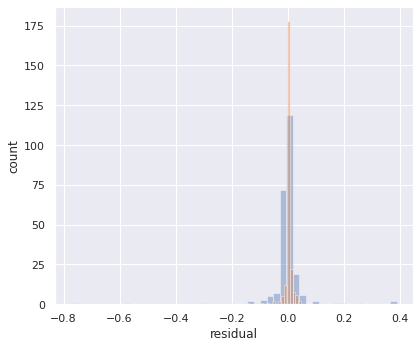

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()

# compute the residuals
res_re = y_test_re.values.reshape(-1,) - y_test_re_pred
res_im = y_test_im.values.reshape(-1,) - y_test_im_pred

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.distplot(res_re,
             kde=False,
             label='$\mathrm{Re}(exp)$',
             ax=ax
            )
sns.distplot(res_im,
             kde=False,
             label='$\mathrm{Im}(exp)$',
             ax=ax
            )
ax.set(title='',
       xlabel='residual',
       ylabel='count'
      )

os.makedirs('./img', exist_ok=True)
plt.tight_layout()
plt.savefig('./img/stacknet_histogram.pdf', dpi=150, format='pdf')

In [17]:
data_re = pd.DataFrame({'real': y_test_re.values.reshape(-1,),
                        'predictions': y_test_re_pred.reshape(-1,)
                       }
                      )
data_im = pd.DataFrame({'real': y_test_im.values.reshape(-1,),
                        'predictions': y_test_im_pred.reshape(-1,)
                       }
                      )

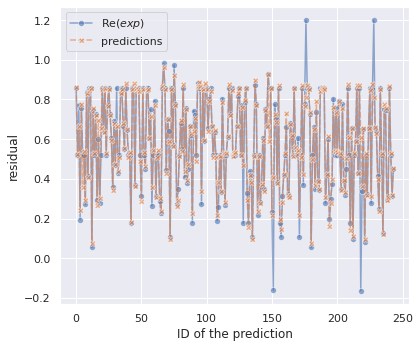

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data_re,
             markers=True,
             alpha=0.6,
             ax=ax
            )
ax.set(title='',
       xlabel='ID of the prediction',
       ylabel='residual'
      )
ax.legend(['$\mathrm{Re}(exp)$', 'predictions'], loc='best')

os.makedirs('./img', exist_ok=True)
plt.tight_layout()
plt.savefig('./img/stacknet_predictions_re.pdf', dpi=150, format='pdf')

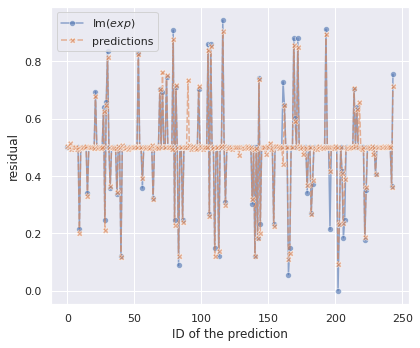

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=data_im,
             markers=True,
             alpha=0.6,
             ax=ax
            )
ax.set(title='',
       xlabel='ID of the prediction',
       ylabel='residual'
      )
ax.legend(['$\mathrm{Im}(exp)$', 'predictions'], loc='best')

os.makedirs('./img', exist_ok=True)
plt.tight_layout()
plt.savefig('./img/stacknet_predictions_im.pdf', dpi=150, format='pdf')

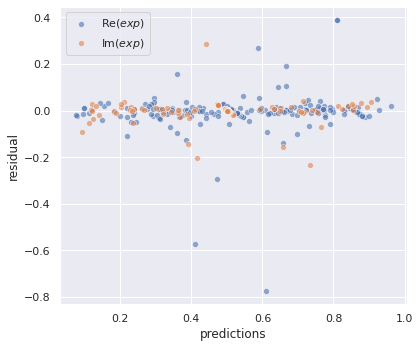

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=y_test_re_pred.reshape(-1,),
                y=res_re,
                alpha=0.6,
                ax=ax
               )
sns.scatterplot(x=y_test_im_pred.reshape(-1,),
                y=res_im,
                alpha=0.6,
                ax=ax
               )
ax.set(title='',
       xlabel='predictions',
       ylabel='residual'
      )
ax.legend(['$\mathrm{Re}(exp)$', '$\mathrm{Im}(exp)$'], loc='best')

os.makedirs('./img', exist_ok=True)
plt.tight_layout()
plt.savefig('./img/stacknet_resplot.pdf', dpi=150, format='pdf')